# Github Live Tracker Project -- Demo and Explanation

Responsibilities:
- [Dmytro Ostapenko](https://github.com/dima1034) -- work with Github API
- [Valentyn Yukhymenko](https://github.com/BaLiKfromUA) -- data processing according to tasks, making it work with API part + demo

In [1]:
import os

os.environ['ACCESS_TOKEN'] = 'add your token'

### New Repo Processor Demo -- Interesting insights about Valentyn's nickname

Task:
> Highlight the new projects that included the searched keyword. (Assume you have a data store that stores all streamed data so you can track if the given project was there before or not)

For demo purposes, as a datastore, we would use prepopulated in-memory dictionary.

Let's search for Valentyn's github nickname -- `BaLiKfromUA`


In [2]:
from reactivex import Observable

import github_client as gh
import new_repo_processor as new_repo
from message import GithubEvent

from new_repo_processor import ReposPerKeywordStorage

keyword = "BaLiKfromUA"

storage: ReposPerKeywordStorage = {
    keyword: {"BaLiKfromUA/pylox"}  # store Valentyn's repo which contains his nickname in README links
}

fetched_data: Observable[GithubEvent] = await gh.fetch_data_as_observable(keyword)  # get GH data as stream
data_processor = new_repo.filter_new_repos(storage)  # carry storage with data processor

data_pipeline = data_processor(fetched_data)  # pipe fetched data and data processor

# output relevant repo names
data_pipeline.subscribe(
    on_next=lambda event: print(f"For keyword {event.keyword}, new repo was found -- {event.repo_name}"),
    on_error=print,
    on_completed=lambda: print("New repo tracking completed")
)

For keyword BaLiKfromUA, new repo was found -- darkbot-reloaded/DarkBotAPI
New repo tracking completed


If we check [darkbot-reloaded/DarkBotAPI](https://github.com/darkbot-reloaded/DarkBotAPI) for given keyword, we would find a link to Valentyn's old gist, lol.

[https://github.com/darkbot-reloaded/DarkBotAPI/blob/9a9ca286a3d309d589b69ca4ab841339a176bf3d/config/pmd/pmd-rules.xml#L88](https://github.com/darkbot-reloaded/DarkBotAPI/blob/9a9ca286a3d309d589b69ca4ab841339a176bf3d/config/pmd/pmd-rules.xml#L88)

### Language statistics demo -- todolist implementations
Task:
> Provide statistics on the programming language in which the keyword was mentioned (using that statistic, we should be able to build a frequency graph where Y is the number of projects written in a specific programming language where the keyword was mentioned and X is a programming language.)

Let's search for projects which use `velox.api.layer0` dependency and get a statistics about such projects

Lang stats calculation completed


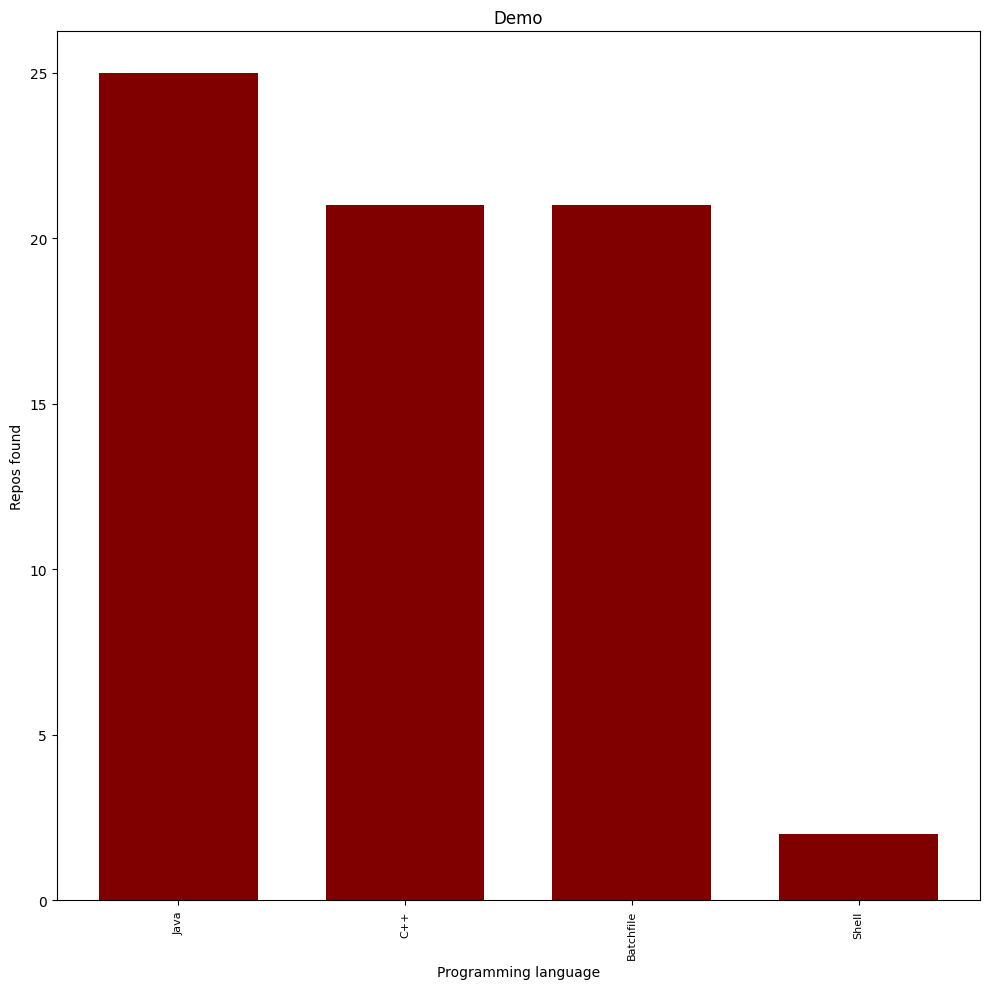

In [2]:
import matplotlib.pyplot as plt
from reactivex import Observable

import github_client as gh
import language_stats_processor as lang
from message import GithubEvent

keyword = "velox.api.layer0"

fetched_data: Observable[GithubEvent] = await gh.fetch_data_as_observable(keyword)  # get GH data as stream
data_processor = lang.get_lang_stats(dict())  # carry in-memory storage with data processor

data_pipeline = data_processor(fetched_data)  # pipe fetched data and data processor

stats = {}


def setter(event: lang.LangStats):
    stats[event.lang] = event.cnt


data_pipeline.subscribe(on_next=setter, on_error=print,
                        on_completed=lambda: print("Lang stats calculation completed"))

langs = list(stats.keys())
cnts = list(stats.values())

fig = plt.figure(figsize=(10, 10))
plt.bar(langs, cnts, color='maroon', width=0.7)

plt.xlabel("Programming language")
plt.ylabel("Repos found")
plt.title("Demo")

# Adjust font size and rotation for better readability
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()

The fact that Java is leading connected to the fact that library is written on Java so stats look good! C++ is mentioned because of ability to call C++ code via JNI functionality directly from Java code.

### Top 5 projects

Task:
> Highlight top 5 projects in which the given keyword was mentioned most of the time during the last day

For this demo I didn't come up with good real world example, so will show a synthetic one with hardcoded data

In [1]:
from datetime import datetime, timedelta
from message import GithubEvent

from reactivex import from_iterable

import top_mentioned_projects_processor as top

# GIVEN
events = [
    GithubEvent(keyword="job", repo_fullname="python-org/CPython", stars_cnt=40_000,
                found_date=datetime.now() - timedelta(hours=4), langs=["C", "python"]),
    GithubEvent(keyword="job", repo_fullname="rust-org/rust", stars_cnt=20_000,
                found_date=datetime.now() - timedelta(hours=2), langs=["Rust", "C++"]),
    GithubEvent(keyword="different keyword", repo_fullname="very popular repo", stars_cnt=100_000,
                found_date=datetime.now() - timedelta(hours=3), langs=["Javascript"]),
    GithubEvent(keyword="job", repo_fullname="google/go", stars_cnt=50_000,
                found_date=datetime.now() - timedelta(hours=2, minutes=10), langs=["Go", "C++"]),
    GithubEvent(keyword="job", repo_fullname="BaLiKfromUA/pylox", stars_cnt=3,
                found_date=datetime.now() - timedelta(hours=2), langs=["Python"]),
    GithubEvent(keyword="job", repo_fullname="torvalds/linux", stars_cnt=100_000,
                found_date=datetime.now() - timedelta(hours=10), langs=["C"]),
    GithubEvent(keyword="job", repo_fullname="hashicorp/golang-lru", stars_cnt=4100,
                found_date=datetime.now() - timedelta(days=2), langs=["Go"]),
]

data_processor = top.get_top_5_mentioned_projects("job")
source_stream = from_iterable(events)

# WHEN
result = []
data_processor(source_stream).subscribe(on_next=result.append, on_error=print, on_completed=print)

# THEN
print(result)


['torvalds/linux', 'google/go', 'python-org/CPython', 'rust-org/rust', 'BaLiKfromUA/pylox']


We do not see "golang-lru" because of date and do not see "very popular repo" because of different keyword. Results are sorted by stars.